# Description

- This is an analysis notebook

## Features

## todo:
- my_positions
    - calculate approx product price per turn
    - calculate total inventory value + total net worth (aka pnl)
- visualize book

In [1]:
from IPython.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interact
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import json
import copy
import traceback

import matplotlib as mpl
from matplotlib import pyplot as plt

In [3]:
from log_parser import process_file


# parameters

In [4]:
# _fname = "../replays/local.log"
_fname = "../replays/day1-log11.log"
_time_step = 100
_max_time = 100000
_num_close_turns = 30
_symbols = ["BANANAS", "PEARLS"]
_products = ["BANANAS", "PEARLS"]

print("_fname", _fname)


_fname ../replays/day1-log11.log


# pre processing

In [5]:
# load data from file

obj = process_file(_fname, start_sep="__game_state_start", end_sep="__game_state_end")

raw_df = pd.DataFrame(obj)

listings = pd.DataFrame(raw_df["listings"][0])
# products = set(listings.T["product"])
raw_df = raw_df.drop("listings", axis=1)
raw_df = raw_df.rename({
    "timestamp": "time",
    "order_depths": "book",
}, axis=1)

missing_times = set([i for i in range(0, _max_time, _time_step)]) - set(raw_df["time"])
print("num missing_times", len(missing_times))
print("missing_times", sorted(missing_times))


Reading from input file ../replays/day1-log11.log
num missing_times 1
missing_times [26600]


In [6]:
# load order info from file
obj = process_file(_fname, start_sep="__turn_end_start", end_sep="__turn_end_end")
raw_records = pd.DataFrame(obj)

missing_times = set([i for i in range(0, _max_time, _time_step)]) - set(raw_records["time"])
print("num missing_times", len(missing_times))
print("missing_times", sorted(missing_times))

Reading from input file ../replays/day1-log11.log
num missing_times 2
missing_times [26600, 53200]


### add turns

In [7]:
# add turns (vs time)

all_times = raw_df["time"]
turn2time_map = all_times.to_dict()
time2turn_map = {v: k for k, v in turn2time_map.items()}
raw_df["turn"] = raw_df["time"].map(time2turn_map)

raw_df.index = raw_df["turn"]

### ref_stat_df
- the EMA values that were calculated during the program
- quote_mids during program
- fair valeus calculated during program

In [8]:
# ref_emas contains EMA values that were used during the program
ref_emas = raw_records["best_emas"].apply(pd.Series).round(2)
ref_emas = pd.concat([ref_emas, raw_records["time"]], axis=1)

ref_ema_df = ref_emas.melt(id_vars=["time"], var_name="symbol", value_name="ref_ema") \
                        .sort_values(by=["time", "symbol"]) \
                        .reset_index(drop=True)


In [9]:
# large_quote_mid
quote_mids = raw_records["quote_mids"].apply(pd.Series)
quote_mids = pd.concat([quote_mids, raw_records["time"]], axis=1)

quote_mid_df = quote_mids.melt(id_vars=["time"], var_name="symbol", value_name="quote_mid") \
                        .sort_values(by=["time", "symbol"]) \
                        .reset_index(drop=True)


# large_quote_mid
use_quote_mids = raw_records["use_quote_mids"].apply(pd.Series)
use_quote_mids = pd.concat([use_quote_mids, raw_records["time"]], axis=1)

use_quote_mid_df = use_quote_mids.melt(id_vars=["time"], var_name="symbol", value_name="use_quote_mid") \
                        .sort_values(by=["time", "symbol"]) \
                        .reset_index(drop=True)



In [10]:
fair_values = raw_records["fair_values"].apply(pd.Series)
fair_values = pd.concat([fair_values, raw_records["time"]], axis=1)

fair_value_df = fair_values.melt(id_vars=["time"], var_name="symbol", value_name="fair_value") \
                        .sort_values(by=["time", "symbol"]) \
                        .reset_index(drop=True)


In [11]:
ref_stat_df = pd.concat([
    ref_ema_df.set_index(["time", "symbol"]),
    quote_mid_df.set_index(["time", "symbol"]),
    use_quote_mid_df.set_index(["time", "symbol"]),
    fair_value_df.set_index(["time", "symbol"]),
], axis=1).reset_index()

In [12]:
ref_stat_df

,time,symbol,ref_ema,quote_mid,use_quote_mid,fair_value
0,0,BANANAS,4896.00,4895.5,True,4895.5
1,0,PEARLS,10001.50,10000.0,True,10000.0
2,100,BANANAS,4896.14,4895.0,True,4895.0
3,100,PEARLS,10001.64,10000.0,True,10000.0
4,200,BANANAS,4896.08,4895.5,True,4895.5
...,...,...,...,...,...,...
1991,99700,PEARLS,9999.40,10000.0,True,10000.0
1992,99800,BANANAS,4893.56,4893.5,True,4893.5
1993,99800,PEARLS,9999.36,10000.0,True,10000.0
1994,99900,BANANAS,4893.55,4893.0,True,4893.0


### book_tops

#### modify raw_df["book"] to be all ints

In [13]:
# modify raw_df["book"] to be all ints
raw_df["book"] = raw_df["book"].apply(lambda x: {
    sym: {
        typ: {
            int(k) : v for k, v in orders.items()
        }
        for typ, orders in all_orders.items()
    }
    for sym, all_orders in x.items()
})

In [14]:
book_data = []
book_cols = []

cmp = lambda k : tuple([int(k[0]), int(k[1])])

for sym in _symbols:
    ### buys
    col = raw_df["book"].apply(lambda x: x[sym])
    # convert dicts into int -> int
    col = col.apply(lambda x : [(int(k), v) for k, v in x["buy_orders"].items()])
    col = col.apply(lambda x : sorted(x, reverse=True))
    col = col.apply(lambda x : x[0][0] if len(x) > 0 else np.nan).astype(float)
    
    book_data += [col]
    book_cols += [f"{sym}_best_buy"]
    
    
    ### sells
    col = raw_df["book"].apply(lambda x: x[sym])
    col = col.apply(lambda x : [(int(k), v) for k, v in x["sell_orders"].items()])
    col = col.apply(lambda x : sorted(x, reverse=False))
    col = col.apply(lambda x: x[0][0] if len(x) > 0 else np.nan).astype(float)
    
    book_data += [col]
    book_cols += [f"{sym}_best_sell"]
    
    
book_tops = pd.concat(book_data, axis=1)
book_tops.columns = book_cols

# all book tops
for sym in _symbols:
    book_tops[f"{sym}_mid"] = (book_tops[f"{sym}_best_buy"] + book_tops[f"{sym}_best_sell"]) / 2
    book_tops[f"{sym}_spread"] = book_tops[f"{sym}_best_sell"] - book_tops[f"{sym}_best_buy"]
    
    print("missing mids", sym, list(book_tops.index[book_tops[f"{sym}_mid"].isna()]))
    
    book_tops[f"{sym}_mid"] = book_tops[f"{sym}_mid"].bfill()
    assert book_tops[f"{sym}_spread"].all() > 0

# sort columns
book_tops = book_tops.reindex(sorted(book_tops.columns), axis=1)
book_tops["time"] = raw_df["time"]



missing mids BANANAS []
missing mids PEARLS []


In [15]:
num_data_dropna = len(book_tops.dropna())
num_data = len(book_tops)

print(f"Orig count: {num_data}")
print(f"Remaining count: {num_data_dropna}")
print(f"nan count: {num_data - num_data_dropna}")

Orig count: 999
Remaining count: 999
nan count: 0


In [16]:
book_tops

,BANANAS_best_buy,BANANAS_best_sell,BANANAS_mid,BANANAS_spread,PEARLS_best_buy,PEARLS_best_sell,PEARLS_mid,PEARLS_spread,time
turn,,,,,,,,,
0,4893.0,4899.0,4896.0,6.0,9998.0,10005.0,10001.5,7.0,0
1,4897.0,4898.0,4897.5,1.0,10002.0,10004.0,10003.0,2.0,100
2,4892.0,4899.0,4895.5,7.0,9996.0,10004.0,10000.0,8.0,200
3,4898.0,4900.0,4899.0,2.0,9995.0,10005.0,10000.0,10.0,300
4,4894.0,4896.0,4895.0,2.0,9998.0,10004.0,10001.0,6.0,400
...,...,...,...,...,...,...,...,...,...
994,4889.0,4896.0,4892.5,7.0,9995.0,9998.0,9996.5,3.0,99500
995,4889.0,4892.0,4890.5,3.0,9995.0,10005.0,10000.0,10.0,99600
996,4892.0,4896.0,4894.0,4.0,9995.0,10005.0,10000.0,10.0,99700


In [17]:
def report_issue_and_continue(condition, fail_msg):
    try:
        assert condition
    except:
        traceback.print_exc()
        display(fail_msg)

### func - flatten_trades() + mark my trades

In [18]:
def flatten_trades(raw_df, col, is_me):
    # get market trades

    data = []
    for index, row  in raw_df.iterrows():
        all_trades = list(row[col].values())
        for sym_trades in all_trades:
            for trade in sym_trades:
                trade["time"] = row["time"] # fill time
                trade["turn"] = row["turn"] # fill time
            data += sym_trades

    df = pd.DataFrame(data)
    # print(df.columns)
    df = df.rename({"timestamp": "order_time"}, axis=1)
    
    # calculate info about my trades
    df["is_me"] = is_me
    df["my_buy"] = df["buyer"] == "SUBMISSION"
    df["my_sell"] = df["seller"] == "SUBMISSION"
    df["my_quantity"] = df["quantity"] * (df["my_buy"].astype(int) - df["my_sell"].astype(int))
    df["self_trade"] = df["my_buy"] & df["my_sell"]
    
    # report self trades
    self_trades = df[df["self_trade"]]
    report_issue_and_continue( len(self_trades) == 0, self_trades)
    
    return df

### dup trade filtering -> market_trades, my_trades, trade_df

In [19]:
# get my_trades, market_trades, and trade_df (all_trades)

market_trades = flatten_trades(
    raw_df, 
    "market_trades", 
    is_me=False
).sort_values(by="time")

my_trades = flatten_trades(
    raw_df, 
    "own_trades", 
    is_me=True
).sort_values(by="time")

market_trades = market_trades.drop_duplicates(subset=["buyer", "price", "quantity", "seller", "symbol", "order_time"])
# my_trades = my_trades.drop_duplicates(subset=["buyer", "price", "quantity", "seller", "symbol", "order_time"])


# ## old filter methods
# # filter market trades (only keep those where order_time = fill_time)
# market_trades = market_trades[market_trades["time"] == market_trades["order_time"]]

# filter my_trades (only keep those where fill_time = order_time + 100)
my_trades = my_trades[my_trades["time"] <= my_trades["order_time"] + _time_step]
## end of old filter methods

trade_df = pd.concat([market_trades, my_trades])

sum_cols = ["quantity", "my_quantity"]

# aggregate quantity over similar trades
trade_df = trade_df.groupby(list(set(trade_df.columns) - set(sum_cols)))[sum_cols].sum().reset_index()[trade_df.columns]
trade_df = trade_df.sort_values(by=["time", "symbol"]).reset_index(drop=True)



trade_df = trade_df.sort_values(by="time").reset_index(drop=True)

# add ref_stats to trade_df
trade_df = trade_df.merge(ref_stat_df, left_on=["order_time", "symbol"], right_on=["time", "symbol"], suffixes=(None, "_ignore"))
trade_df = trade_df.drop("time_ignore", axis=1)
trade_df["buy_edge"] = trade_df["fair_value"] - trade_df["price"]

my_trades = trade_df[trade_df["is_me"]].copy()
market_trades = trade_df[~trade_df["is_me"]].copy()


In [20]:
my_trades.shape, market_trades.shape, trade_df.shape

((501, 18), (212, 18), (713, 18))

### volume summary

In [21]:
for sym in _symbols:
    print(sym)
    
    my_sym_trades = my_trades[my_trades["symbol"] == sym]
    my_volume = my_sym_trades["quantity"].abs().sum()
    market_sym_trades = market_trades[market_trades["symbol"] == sym]
    market_volume = market_sym_trades["quantity"].abs().sum()
    
    my_vol_perc = my_volume / (my_volume + market_volume) * 100
    
    print("[THEM]\t count:", len(market_sym_trades), "\tvolume:", market_volume)
    print("[MY]\t count:", len(my_sym_trades), "\tvolume:", my_volume)
    print(f"[MY]\t vol%: {round(my_vol_perc, 2)}%")

BANANAS
[THEM]	 count: 111 	volume: 311
[MY]	 count: 255 	volume: 828
[MY]	 vol%: 72.7%
PEARLS
[THEM]	 count: 101 	volume: 213
[MY]	 count: 246 	volume: 669
[MY]	 vol%: 75.85%


### my_position validation

In [22]:
# get my_positions
my_positions = pd.DataFrame(list(raw_df["position"])).fillna(0)

# add any products of zero quantity
for prod in _products:
    if prod not in my_positions:
        my_positions[prod] = 0
        
my_positions[["time", "turn"]] = raw_df[["time", "turn"]]
my_positions = my_positions.sort_values(by="time")

# add cash to my_positions
fixed_pos_data = []
pos_data = []
cur_positions = { prod: 0 for prod in _products }
cur_positions["total_cash"] = 0
for sym in _symbols:
    cur_positions[f"{sym}_cash"] = 0
fixed_positions = copy.deepcopy(cur_positions)

cur_time = turn2time_map[0]

def record_pos_data(cur_positions, fixed_positions, cur_time, pos_data, fixed_pos_data):
    global my_positions
    
    # copy orig pos
    pos_data += [copy.deepcopy(cur_positions)]
    
    # fix positions if necessary
    cur_turn = time2turn_map[cur_time]
        
    # init fixed_positions for this turn
    for prod in _products:
        diff = my_positions[prod][cur_turn] - fixed_positions[prod]
        price = book_tops[f"{prod}_mid"][cur_turn]
        
        if diff != 0:
            print(f"[Fixed trade] Turn: {cur_turn}, time: {cur_time}, {prod} {diff} @ {price}")
            
        fixed_positions[prod] += diff
        fixed_positions["total_cash"] += -1 * diff * price
        fixed_positions[f"{prod}_cash"] += -1 * diff * price

    # copy fixed pos
    fixed_pos_data += [copy.deepcopy(fixed_positions)]
    
    
for index, row in my_trades.iterrows():
    row_time = row["time"]
    while cur_time < row["time"]:
        record_pos_data(cur_positions, fixed_positions, cur_time, pos_data, fixed_pos_data)
        cur_time = turn2time_map[len(pos_data)]
        
    prod = listings[row["symbol"]]["product"]
    # update cur
    cur_positions["total_cash"] += -1 * row["price"] * row["my_quantity"]
    cur_positions[f"{prod}_cash"] += -1 * row["price"] * row["my_quantity"]
    cur_positions[prod] += row["my_quantity"]
    
    # update fixed
    fixed_positions["total_cash"] += -1 * row["price"] * row["my_quantity"]
    fixed_positions[f"{prod}_cash"] += -1 * row["price"] * row["my_quantity"]
    fixed_positions[prod] += row["my_quantity"]

# add for remaining turns
while cur_time < max(turn2time_map.values()):
    record_pos_data(cur_positions, fixed_positions, cur_time, pos_data, fixed_pos_data)
    cur_time = turn2time_map[len(pos_data)]

record_pos_data(cur_positions, fixed_positions, cur_time, pos_data, fixed_pos_data)



# pos_df contains calculated position data (based on my_trades)
pos_df = pd.DataFrame(pos_data).sort_index(axis=1)

# add to my_positions
for prod in ["total", *_products]:
    my_positions[f"{prod}_cash"] = pos_df[f"{prod}_cash"]
# my_positions["total_cash"] = pos_df["total_cash"]
my_positions = my_positions.sort_index(axis=1)


try:
    for prod in _products:
        bad_inds = my_positions.index[my_positions[prod] != pos_df[prod]]
        if len(bad_inds) > 0:
            print("true pos")
            display(my_positions.loc[bad_inds])
            print("calculated pos")
            display(pos_df.loc[bad_inds])
            assert False, f"Failed check for product: `{prod}`"
except AssertionError:
    traceback.print_exc()
    
    print("Using fixed_pos_df['total_cash']")
    fixed_pos_df = pd.DataFrame(fixed_pos_data).sort_index(axis=1)
    # my_positions["total_cash"] = fixed_pos_df["total_cash"]
    for prod in ["total", *_products]:
        my_positions[f"{prod}_cash"] = fixed_pos_df[f"{prod}_cash"]

[Fixed trade] Turn: 179, time: 17900, PEARLS 3.0 @ 9996.5
[Fixed trade] Turn: 180, time: 18000, PEARLS -3.0 @ 10000.0
[Fixed trade] Turn: 266, time: 26700, PEARLS 4.0 @ 10000.0
[Fixed trade] Turn: 532, time: 53300, BANANAS -1.0 @ 4895.5
[Fixed trade] Turn: 599, time: 60000, PEARLS 2.0 @ 9997.0
[Fixed trade] Turn: 600, time: 60100, PEARLS -2.0 @ 10000.0
[Fixed trade] Turn: 662, time: 66300, PEARLS -1.0 @ 10001.0
[Fixed trade] Turn: 663, time: 66400, PEARLS 1.0 @ 10000.0
[Fixed trade] Turn: 757, time: 75800, BANANAS -1.0 @ 4894.5
[Fixed trade] Turn: 758, time: 75900, BANANAS 1.0 @ 4892.5
[Fixed trade] Turn: 956, time: 95700, PEARLS 1.0 @ 10003.0
[Fixed trade] Turn: 957, time: 95800, PEARLS -1.0 @ 9997.0
true pos


,BANANAS,BANANAS_cash,PEARLS,PEARLS_cash,time,total_cash,turn
532,-13.0,59395.0,-15.0,190767.0,53300,250162.0,532
533,-13.0,59395.0,-15.0,190767.0,53400,250162.0,533
534,-13.0,59395.0,-14.0,180769.0,53500,240164.0,534
535,-13.0,59395.0,-14.0,180769.0,53600,240164.0,535
536,-3.0,10465.0,-14.0,180769.0,53700,191234.0,536
...,...,...,...,...,...,...,...
994,-7.0,30745.0,-10.0,141586.0,99500,172331.0,994
995,-20.0,94380.0,-7.0,111592.0,99600,205972.0,995
996,-19.0,89488.0,-7.0,111592.0,99700,201080.0,996
997,-19.0,89488.0,-5.0,91600.0,99800,181088.0,997


calculated pos


,BANANAS,BANANAS_cash,PEARLS,PEARLS_cash,total_cash
532,-12,59395.0,-19,190767.0,250162.0
533,-12,59395.0,-19,190767.0,250162.0
534,-12,59395.0,-18,180769.0,240164.0
535,-12,59395.0,-18,180769.0,240164.0
536,-2,10465.0,-18,180769.0,191234.0
...,...,...,...,...,...
994,-6,30745.0,-14,141586.0,172331.0
995,-19,94380.0,-11,111592.0,205972.0
996,-18,89488.0,-11,111592.0,201080.0
997,-18,89488.0,-9,91600.0,181088.0


Using fixed_pos_df['total_cash']


Traceback (most recent call last):
  File "/var/folders/fv/6rc0c0r11hn6xpyhsr9z6rrc0000gn/T/ipykernel_14488/868700199.py", line 92, in <module>
    assert False, f"Failed check for product: `{prod}`"
AssertionError: Failed check for product: `BANANAS`


### Construct postbook
- Want to see what the world looked like, after we submit our orders

In [23]:
f_buy = lambda x : sorted(list(x.items()), reverse=True)
f_sell = lambda x : sorted(list(x.items()), reverse=False)
f_my_buy = lambda x : sorted([(el["price"], el["quantity"]) for el in x], reverse=True)
f_my_sell = lambda x : sorted([(el["price"], el["quantity"]) for el in x], reverse=False)

book = pd.merge(raw_df[["book", "time"]], raw_records, on="time")
new_book = book[["time"]].copy()

for sym in _symbols:
    new_book[f"{sym}_buys"] = book["book"].apply(lambda x : f_buy(x[sym]["buy_orders"]))
    new_book[f"{sym}_sells"] = book["book"].apply(lambda x : f_sell(x[sym]["sell_orders"]))
    new_book[f"{sym}_my_buys"] = book["my_orders"].apply(lambda x : f_my_buy(x[sym]["buy_orders"]))
    new_book[f"{sym}_my_sells"] = book["my_orders"].apply(lambda x : f_my_sell(x[sym]["sell_orders"]))

book = new_book


In [24]:
ref_stat_df

,time,symbol,ref_ema,quote_mid,use_quote_mid,fair_value
0,0,BANANAS,4896.00,4895.5,True,4895.5
1,0,PEARLS,10001.50,10000.0,True,10000.0
2,100,BANANAS,4896.14,4895.0,True,4895.0
3,100,PEARLS,10001.64,10000.0,True,10000.0
4,200,BANANAS,4896.08,4895.5,True,4895.5
...,...,...,...,...,...,...
1991,99700,PEARLS,9999.40,10000.0,True,10000.0
1992,99800,BANANAS,4893.56,4893.5,True,4893.5
1993,99800,PEARLS,9999.36,10000.0,True,10000.0
1994,99900,BANANAS,4893.55,4893.0,True,4893.0


In [25]:
def get_book(sym, time):
    bk = book[book["time"] == time]
    
    if len(bk) == 0:
        print(f"No data for {sym} at time {time}")
        return None, None, None, None
    
    buys = bk[f"{sym}_buys"].iloc[0]
    sells = bk[f"{sym}_sells"].iloc[0]
    my_buys = bk[f"{sym}_my_buys"].iloc[0]
    my_sells = bk[f"{sym}_my_sells"].iloc[0]
    
    return buys, sells, my_buys, my_sells


def get_trades(sym, time):
    market_ts = market_trades[(market_trades["symbol"] == sym) & (market_trades["time"] == time)]
    my_ts = my_trades[(my_trades["symbol"] == sym) & (my_trades["time"] == time)]
    
    market_ts = market_ts.groupby(["symbol", "time", "price"])[["quantity"]].sum().reset_index()
    my_ts = my_ts.groupby(["symbol", "time", "price", "my_buy", "my_sell"])[["quantity"]].sum().reset_index()
    
    return market_ts, my_ts


def get_ref_ema(sym, time):
    return ref_emas.set_index("time").loc[time][sym]


def get_fair_value(sym, time):
    return fair_values.set_index("time").loc[time][sym]


def show_book(sym, 
              time, 
              xmin=None, 
              xmax=None,
              ymin=None, 
              ymax=None,
             ):
        
    # set figsize    
    plt.figure(figsize=(15,6))
    
    buys, sells, my_buys, my_sells = get_book(sym, time)
    if buys is None:
        return
    market_ts, my_ts = get_trades(sym, time + _time_step)
    ref_ema = get_ref_ema(sym, time)
    fair_value = get_fair_value(sym, time)
    
    f = lambda x : pd.DataFrame(x, columns=["price", "quantity"])
    
    buys, sells, my_buys, my_sells = f(buys), f(sells), f(my_buys), f(my_sells)
    
    # make bars have correct sign
    sells["quantity"] *= -1
    my_buys["quantity"] *= -1
    my_ts["quantity"] *= -1
    
    # plot order book
    if len(buys) > 0:
        plt.bar(buys["price"], buys["quantity"], color="green", label="market buy")
    if len(sells) > 0:
        plt.bar(sells["price"], sells["quantity"], color="red", label="market sells")
    
    if len(my_buys) > 0:
        plt.bar(my_buys["price"], my_buys["quantity"], color="blue", label="my buy")
    if len(my_sells) > 0:
        plt.bar(my_sells["price"], my_sells["quantity"], color="orange", label="my sell")
    
    # plot trades
    if len(market_ts) > 0:
        plt.bar(market_ts["price"], market_ts["quantity"], color=(0, 0, 0, 0), label="market trade", 
                hatch="///", edgecolor="black")
        
    if len(my_ts) > 0:
        plt.bar(my_ts["price"], my_ts["quantity"], color=(0, 0, 0, 0), label="my trade",
                hatch="xxx", edgecolor="black")
    
    
    
    ### draw reference lines
    
    # set xlim, ylim
    if xmin:
        plt.xlim(xmin=xmin)
    if xmax:
        plt.xlim(xmax=xmax)
    if ymin:
        plt.ylim(bottom=ymin)
    if ymax:
        plt.ylim(top=ymax)
    
    # draw horizontal line at 0 
    plt.axhline(y=0.0, color="black", linestyle='-')
    
    # draw true mid
    if len(buys) > 0 and len(sells) > 0:
        true_mid = (buys["price"][0] + sells["price"][0]) / 2
        plt.axvline(x=true_mid, color="red", linestyle='solid', alpha=0.2)
    
    # draw ref ema
    plt.axvline(x=ref_ema, color="orange", linestyle='dotted')
    
    # draw fair_value
    plt.axvline(x=fair_value, color="black", linestyle='solid')
    
    ema_span = raw_records[raw_records["time"] == time]["best_ema_spans"].iloc[0][sym]
    
    ### general figure settings    
    plt.legend(loc="upper center")
    plt.title(f"{sym} book - Time: {time} - ema_span: {ema_span}")
    plt.show()
    
    
    ### print raw info
    print("fair_value", fair_value)
    print("ref_ema", ref_ema)
    
    print("market trades")
    display(market_ts)
    print("my trades")
    display(my_ts)
    
    print("buys")
    display(buys.T)
    print("sells")
    display(sells.T)
    print("my_buys")
    display(my_buys.T)
    print("my_sells")
    display(my_sells.T)
    
    
    
def show_book_simple(
        sym,
        time=0,
        # ymin=None,
        # ymax=None,
        ):
    
    # all trades
    all_trades = trade_df[trade_df["symbol"] == sym]
    
    def flatten(col):
        return [el[0] for l in list(col) for el in l]
    
    # all orders
    market_buys = book[f"{sym}_buys"]
    market_sells = book[f"{sym}_sells"]
    my_buys = book[f"{sym}_my_buys"]
    my_sells = book[f"{sym}_my_sells"]
    # display(market_buys)
    # display(list(market_buys.apply(lambda x : [p for p, q in x])))
    
    # print(market_buys.apply(lambda x : x[))
    
    all_prices = [
        # all trades
        trade_df[trade_df["symbol"] == sym]["price"],
        # all orders
        flatten(market_buys),
        flatten(market_sells),
        flatten(my_buys),
        flatten(my_sells),
    ]
    
    xmin = min([min(x) for x in all_prices])
    xmax = max([max(x) for x in all_prices])
    
    show_book(
        sym, 
        time,
        xmin=xmin - 1,
        xmax=xmax + 1,
        ymin=-50,
        ymax=50,
    )

In [26]:
my_trades[my_trades["order_time"] == 22900]

,buyer,price,quantity,seller,symbol,order_time,time,turn,is_me,my_buy,my_sell,my_quantity,self_trade,ref_ema,quote_mid,use_quote_mid,fair_value,buy_edge
157,,10002.0,2,SUBMISSION,PEARLS,22900,23000,230,True,False,True,-2,False,10000.57,10000.0,True,10000.0,-2.0


In [27]:
raw_records[raw_records["time"] == 22900]["my_orders"].iloc[0]

{'BANANAS': {'buy_orders': [{'price': 4892,
    'quantity': 9,
    'symbol': 'BANANAS'}],
  'sell_orders': [{'price': 4897, 'quantity': -31, 'symbol': 'BANANAS'}]},
 'PEARLS': {'buy_orders': [{'price': 9996, 'quantity': 5, 'symbol': 'PEARLS'}],
  'sell_orders': [{'price': 10002, 'quantity': -2, 'symbol': 'PEARLS'},
   {'price': 10004, 'quantity': -33, 'symbol': 'PEARLS'}]}}

In [28]:
# hatched areas show trades
# bars show orders

# vertical red solid line - true mid price based on book
# vertical black dotted line - EMA (that the program used)


interact(
    show_book_simple,
    sym=["BANANAS", "PEARLS"],
    time=(0, _max_time, _time_step),
)

interactive(children=(Dropdown(description='sym', options=('BANANAS', 'PEARLS'), value='BANANAS'), IntSlider(v…

<function __main__.show_book_simple(sym, time=0)>

### create order df (market)

In [29]:
order_data = []

for side, side_sign in [("buys", 1), ("sells", -1)]:
    for sym in _symbols:

        # expand buy orders
        df = book[f"{sym}_{side}"]
        df = pd.DataFrame(df.apply(pd.Series))
        df["time"] = book["time"]

        # concat columns into array
        data = [df[[col, "time"]].set_axis(labels=["order", "time"], axis=1) for col in df.columns if col != "time"]

        # convert array into order df
        buy_order_df = pd.concat(data).dropna()

        
        # mark buy/sells
        buy_order_df["symbol"] = sym
        
        order_data += [buy_order_df]
        
# agg all data
order_df = pd.concat(order_data)

# expand order into price/quantity
temp_df = order_df["order"].apply(lambda x : pd.Series(x, index=["price", "quantity"]))
order_df = pd.concat([order_df, temp_df], axis=1).drop("order", axis=1)

# sort data
order_df = order_df.sort_values(by=["time", "price"]).reset_index(drop=True)

# merge ref_ema into order_df
order_df = order_df.merge(ref_stat_df, on=["time", "symbol"])

# edge that a taker would receive
order_df["taker_edge"] = -1 * np.sign(order_df["quantity"]) * (order_df["fair_value"] - order_df["price"])

In [30]:
order_df

,time,symbol,price,quantity,ref_ema,quote_mid,use_quote_mid,fair_value,taker_edge
0,0,BANANAS,4892,23,4896.00,4895.5,True,4895.5,-3.5
1,0,BANANAS,4893,9,4896.00,4895.5,True,4895.5,-2.5
2,0,BANANAS,4899,-23,4896.00,4895.5,True,4895.5,-3.5
3,0,PEARLS,9995,23,10001.50,10000.0,True,10000.0,-5.0
4,0,PEARLS,9998,9,10001.50,10000.0,True,10000.0,-2.0
...,...,...,...,...,...,...,...,...,...
6643,99900,PEARLS,9995,27,9999.51,10000.0,True,10000.0,-5.0
6644,99900,PEARLS,9996,1,9999.51,10000.0,True,10000.0,-4.0
6645,99900,PEARLS,9998,6,9999.51,10000.0,True,10000.0,-2.0
6646,99900,PEARLS,10004,-1,9999.51,10000.0,True,10000.0,-4.0


# Analysis
- for info about trades:
    - `trade_df` (all trades)
    - `my_trades` (our trades only)
    - `market_trades` (other people's trades only, not our trades)
- for info about our positions
    - `my_positions`

## General summary

### Estimate Fairs

In [31]:
# estimate fairs
fairs = fair_values.set_index("time").reindex(np.arange(0, _max_time, _time_step)) \
            .ffill().bfill().reset_index()


# mid_cols = [col for col in book_tops.columns if "_mid" in col]
# fairs = book_tops[["time", *mid_cols]]
# fairs.columns = fairs.columns.str.strip('_mid')

fairs

,time,BANANAS,PEARLS
0,0,4895.5,10000.0
1,100,4895.0,10000.0
2,200,4895.5,10000.0
3,300,4896.5,10000.0
4,400,4896.0,10000.0
...,...,...,...
995,99500,4892.5,10000.0
996,99600,4892.5,10000.0
997,99700,4892.5,10000.0
998,99800,4893.5,10000.0


### Estimate PNLs

In [32]:
# estimate pnl
cash_cols = [f"{prod}_cash" for prod in ["total", *_products]]
# cash_cols += [f"{sym}_cash" for sym in _symbols]

for prod in ["total", *_products]:
    my_positions[f"{prod}_pnl"] = my_positions[f"{prod}_cash"]

for prod in _products:
    col = f"{prod}_pnl"
    my_positions[col] += my_positions[prod] * fairs[prod]
    
    col = "total_pnl"
    my_positions[col] += my_positions[prod] * fairs[prod]


#### func -  plot_trades_and_book()

In [33]:
# plot trades
def plot_trades_and_book(
        sym, 
        trade_df, 
        book_df, 
        time_lb=float("-inf"), 
        time_ub=float("inf"), 
        span=21,
        show_mid=False,
        ):
    
    trade_df = trade_df[(time_lb <= trade_df["time"]) & (trade_df["time"] <= time_ub)]
    book_df = book_df[(time_lb <= book_df["time"]) & (book_df["time"] <= time_ub)]
    
    # filter for this symbol only
    plt_df = trade_df
    plt_df = plt_df[plt_df["symbol"] == sym]

    my_buys = plt_df[plt_df["my_quantity"] > 0]
    my_sells = plt_df[plt_df["my_quantity"] < 0]
    their_trades = plt_df[plt_df["my_quantity"] == 0]
    
    
    
    def plot_trades(ax):
        ax.scatter(my_buys["time"], my_buys["price"], c="green", s=25)
        ax.scatter(my_sells["time"], my_sells["price"], c="red", s=25)
        ax.scatter(their_trades["time"], their_trades["price"], c="orange", s=5)
    
    
    book_df = book_df
    
    bids = book_df[f"{sym}_best_buy"]
    asks = book_df[f"{sym}_best_sell"]
    mids = book_df[f"{sym}_mid"]
    smooth_bids = bids.ewm(span=span).mean()
    smooth_asks = asks.ewm(span=span).mean()
    smooth_mids = mids.ewm(span=span).mean()
    
#     plt.figsize(5, 5)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    times = book_df["time"]
    
    # plot book
    ax = axes[0]
    ax.plot(times, bids, c="green", alpha=0.5, linewidth=0.5, label="bid")
    ax.plot(times, asks, c="red", alpha=0.5, linewidth=0.5, label="ask")
    if show_mid:
        ax.plot(times, mids, c="black", alpha=0.25, linewidth=0.5, label="mid")
    ax.set_title(f"Trades and book: {sym}")
    ax.legend()
    plot_trades(ax)
    
    ax = axes[1]
    ax.plot(times, smooth_bids, c="green", alpha=0.5, linewidth=0.5, label="bid")
    ax.plot(times, smooth_asks, c="red", alpha=0.5, linewidth=0.5, label="ask")
    if show_mid:
        ax.plot(times, smooth_mids, c="black", alpha=0.5, linewidth=0.5, label="mid")
    ax.set_title(f"(smooth) Trades and book: {sym}")
    ax.legend()
    plot_trades(ax)

    plt.show()
    

### overall trade/book graph

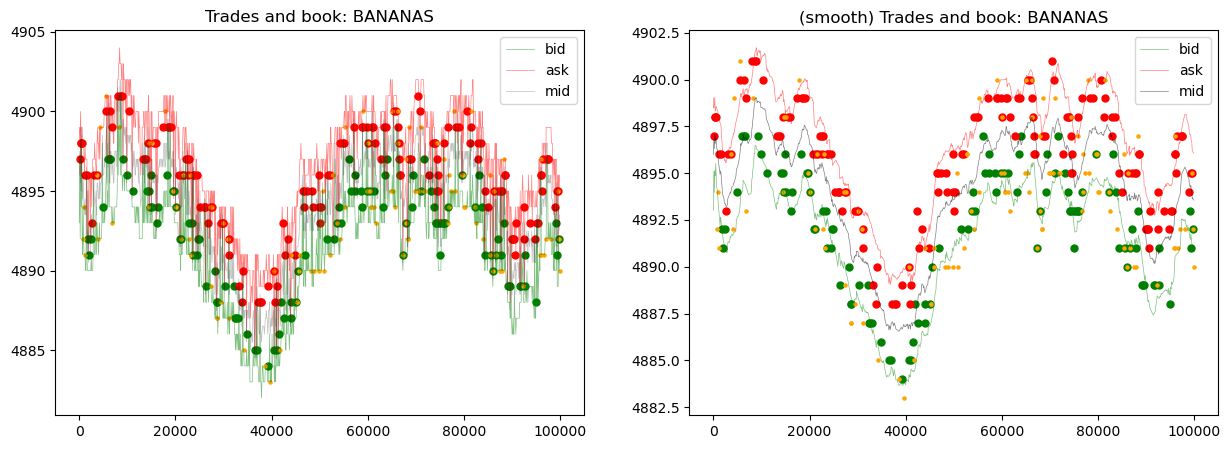

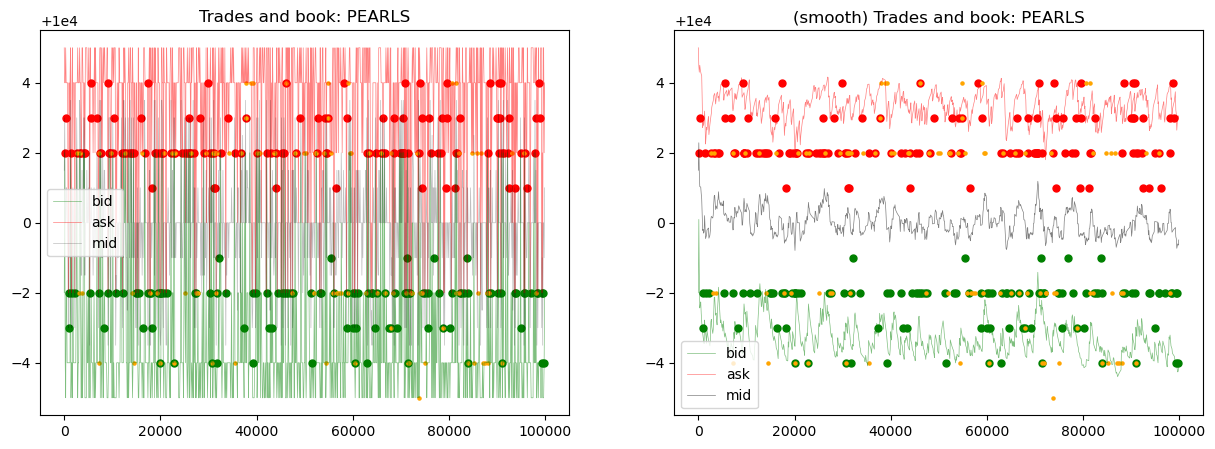

In [34]:
plot_trades_and_book(
    sym="BANANAS", 
    trade_df=trade_df, 
    book_df=book_tops, 
#     time_lb=0, 
#     time_ub=50000, 
    span=21,
    show_mid=True,
)
plot_trades_and_book(
    sym="PEARLS", 
    trade_df=trade_df, 
    book_df=book_tops, 
#     time_lb=0, 
#     time_ub=50000, 
    span=21,
    show_mid=True,
)


### compare ref EMA to true EMA

In [35]:
symbol = "BANANAS"
spans = raw_records["best_ema_spans"].apply(lambda x : x[symbol])
spans.value_counts()

21    998
Name: best_ema_spans, dtype: int64

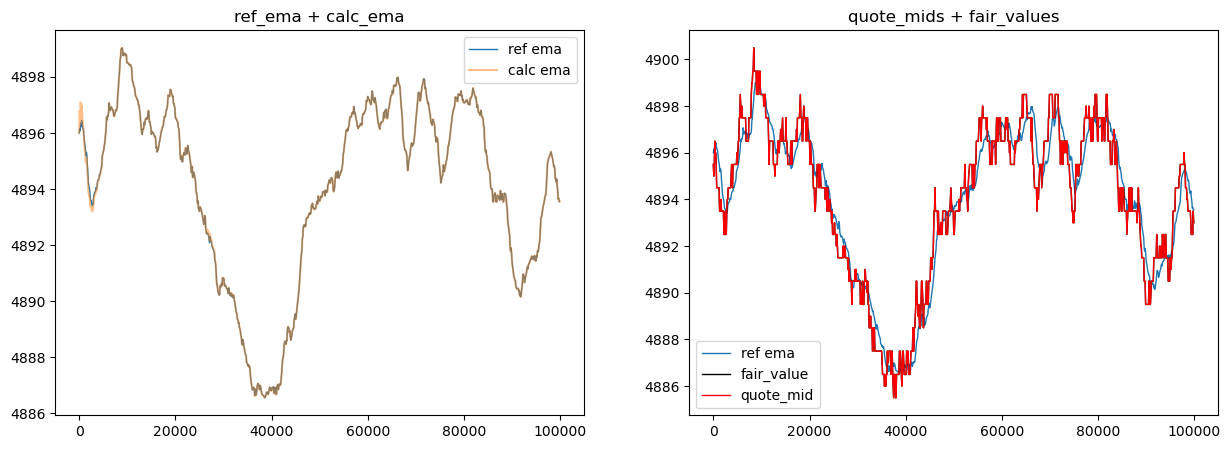

In [36]:
symbol = "BANANAS"

mids = book_tops[f"{symbol}_mid"]
ema = mids.ewm(span=21).mean()

plt.figure(figsize=(15, 5))

plt.subplot(121)

plt.plot(ref_emas["time"], ref_emas[symbol], label="ref ema", alpha=1, linewidth=1)
plt.plot(book_tops["time"], ema, label="calc ema", alpha=0.5)
plt.legend()
plt.title("ref_ema + calc_ema")

plt.subplot(122)

plt.plot(ref_emas["time"], ref_emas[symbol], label="ref ema", alpha=1, linewidth=1)
plt.plot(fair_values["time"], fair_values[symbol], label="fair_value", color="black", alpha=1, linewidth=1)
plt.plot(quote_mids["time"], quote_mids[symbol], label="quote_mid", color="red", alpha=1, linewidth=1)
plt.legend()
plt.title("quote_mids + fair_values")
plt.show()


### PNL Graph

Text(0.5, 1.0, 'PNL')

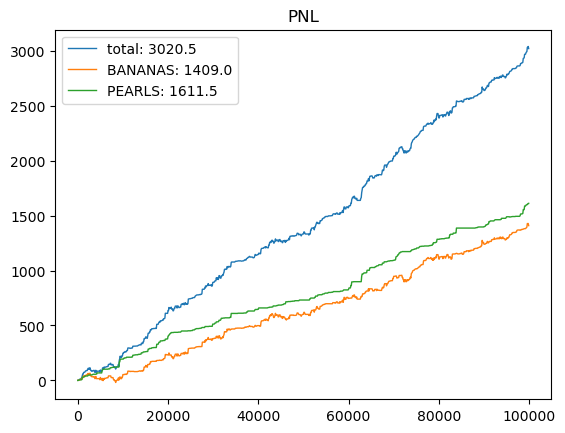

In [37]:
# pnl
for prod in ["total", *_products]:
    pnl = my_positions[f"{prod}_pnl"].iloc[-1]
    plt.plot(my_positions["time"], my_positions[f"{prod}_pnl"], label=f"{prod}: {pnl}", linewidth=1)
    
plt.legend()
plt.title(f"PNL")


### Positions Graph

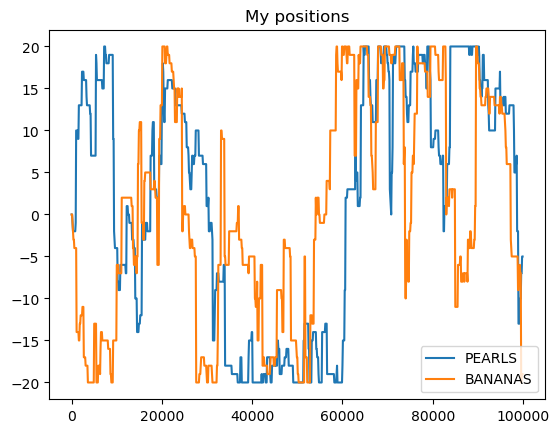

In [38]:
# plot my positions in each product

plt.plot(my_positions["time"], my_positions["PEARLS"], label="PEARLS")
plt.plot(my_positions["time"], my_positions["BANANAS"], label="BANANAS")
plt.title("My positions")
plt.legend()
plt.show()

### Price movements (pct change)

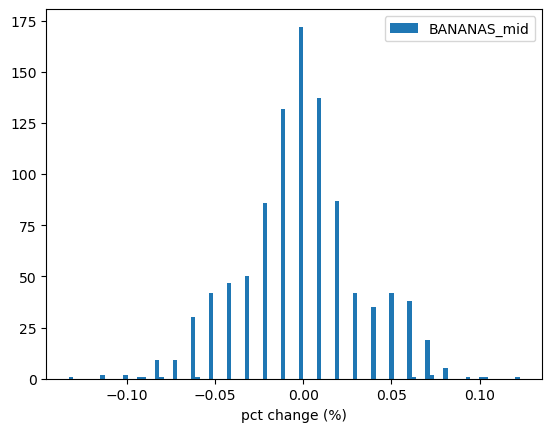

,count,mean,std,min,25%,50%,75%,max
BANANAS_mid,998.0,-0.000045,0.034469,-0.132734,-0.020422,0.0,0.020425,0.122687


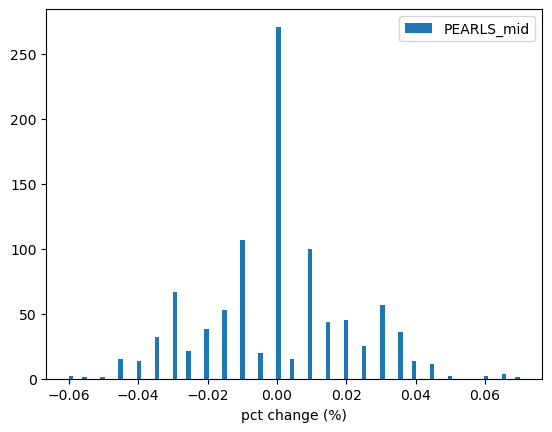

,count,mean,std,min,25%,50%,75%,max
PEARLS_mid,998.0,-0.000003,0.021113,-0.059982,-0.010001,0.0,0.010001,0.070025


In [39]:
# distribution of price movements (pct change)
mids = ["BANANAS_mid", "PEARLS_mid"]

for mid in mids:
    col = book_tops[[mid]]
    diffs = (col.shift(-1) / col).dropna()
    diffs = (diffs - 1) * 100
    plt.hist(diffs, bins=100, label=mid)
    plt.xlabel("pct change (%)")
    plt.legend()
    plt.show()
    display(diffs.describe().T)

### Price movements (actual change)

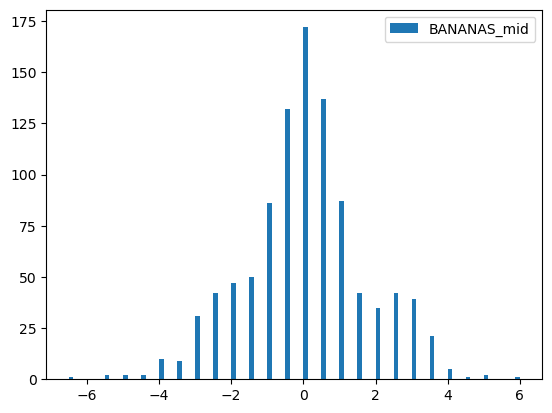

,count,mean,std,min,25%,50%,75%,max
BANANAS_mid,998.0,-0.002505,1.686944,-6.5,-1.0,0.0,1.0,6.0


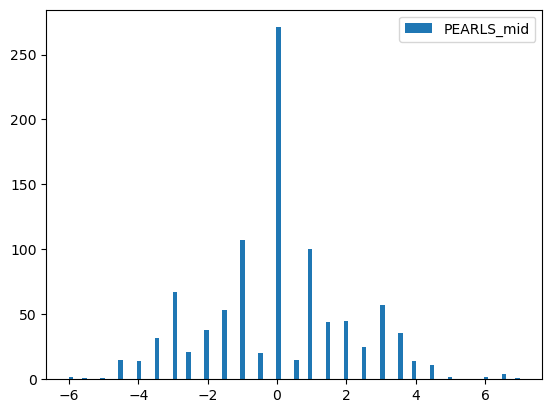

,count,mean,std,min,25%,50%,75%,max
PEARLS_mid,998.0,-0.000501,2.111308,-6.0,-1.0,0.0,1.0,7.0


In [40]:
# distribution of price movements (actual #)
mids = ["BANANAS_mid", "PEARLS_mid"]

for mid in mids:
    col = book_tops[[mid]]
    diffs = (col.shift(-1) - col).dropna()
    plt.hist(diffs, bins=100, label=mid)
    plt.legend()
    plt.show()
    display(diffs.describe().T)


### Spread stats - BANANAS

In [41]:
# spread summary stats

sym = "BANANAS"
spreads = pd.DataFrame(book_tops[f"{sym}_best_sell"] - book_tops[f"{sym}_best_buy"])
spreads.describe().T

,count,mean,std,min,25%,50%,75%,max
0,999.0,5.25025,1.946539,1.0,5.0,6.0,7.0,7.0


### Spread stats - PEARLS

In [42]:
# spread summary stats

sym = "PEARLS"
spreads = pd.DataFrame(book_tops[f"{sym}_best_sell"] - book_tops[f"{sym}_best_buy"])
spreads.describe().T

,count,mean,std,min,25%,50%,75%,max
0,999.0,6.676677,2.545491,2.0,6.0,8.0,8.0,10.0


In [43]:
# quantity stats
trade_df.groupby("time")[["quantity"]].sum().describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,496.0,4.074597,4.208755,1.0,1.0,1.0,1.0,2.0,5.0,11.0,19.0,21.0


In [44]:
book_tops

,BANANAS_best_buy,BANANAS_best_sell,BANANAS_mid,BANANAS_spread,PEARLS_best_buy,PEARLS_best_sell,PEARLS_mid,PEARLS_spread,time
turn,,,,,,,,,
0,4893.0,4899.0,4896.0,6.0,9998.0,10005.0,10001.5,7.0,0
1,4897.0,4898.0,4897.5,1.0,10002.0,10004.0,10003.0,2.0,100
2,4892.0,4899.0,4895.5,7.0,9996.0,10004.0,10000.0,8.0,200
3,4898.0,4900.0,4899.0,2.0,9995.0,10005.0,10000.0,10.0,300
4,4894.0,4896.0,4895.0,2.0,9998.0,10004.0,10001.0,6.0,400
...,...,...,...,...,...,...,...,...,...
994,4889.0,4896.0,4892.5,7.0,9995.0,9998.0,9996.5,3.0,99500
995,4889.0,4892.0,4890.5,3.0,9995.0,10005.0,10000.0,10.0,99600
996,4892.0,4896.0,4894.0,4.0,9995.0,10005.0,10000.0,10.0,99700


In [45]:
book_top_df = book_tops.melt(id_vars=["time"])
cols = book_top_df["variable"].str.split("_", n=1).apply(pd.Series).set_axis(["symbol", "variable"], axis=1)

book_top_df = book_top_df.drop("variable", axis=1).join(cols)


In [46]:
book_top_df

,time,value,symbol,variable
0,0,4893.0,BANANAS,best_buy
1,100,4897.0,BANANAS,best_buy
2,200,4892.0,BANANAS,best_buy
3,300,4898.0,BANANAS,best_buy
4,400,4894.0,BANANAS,best_buy
...,...,...,...,...
7987,99500,3.0,PEARLS,spread
7988,99600,10.0,PEARLS,spread
7989,99700,10.0,PEARLS,spread
7990,99800,6.0,PEARLS,spread


###  taker vs maker stats

BANANAS - my TAKER pnl: 671.5


,count,mean,std,min,25%,50%,75%,max
my_edge,166.0,1.695783,0.731901,0.5,1.5,1.5,2.5,2.5


BANANAS - my MAKER pnl: 838.5


,count,mean,std,min,25%,50%,75%,max
my_edge,89.0,1.955056,0.697563,0.5,1.5,2.5,2.5,2.5


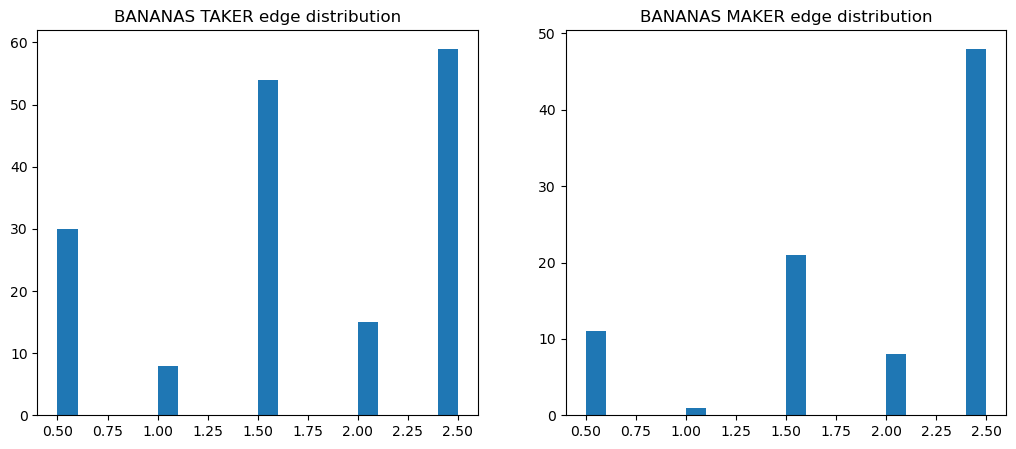

PEARLS - my TAKER pnl: 744.0


,count,mean,std,min,25%,50%,75%,max
my_edge,157.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0


PEARLS - my MAKER pnl: 856.0


,count,mean,std,min,25%,50%,75%,max
my_edge,89.0,2.921348,1.013822,1.0,3.0,3.0,4.0,4.0


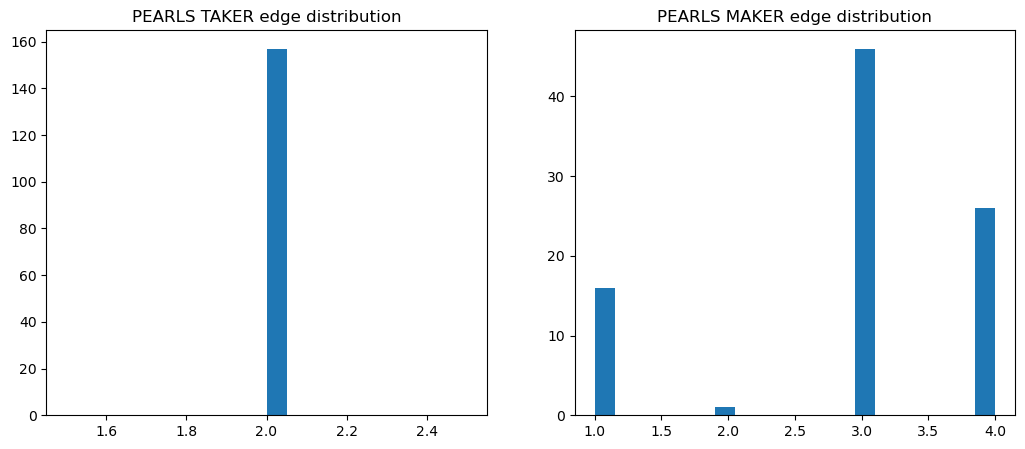

In [47]:
# merge current trades with previous turn's tops
my_trade_df = my_trades.copy()
my_trade_df["time"] -= _time_step

# get col to merge on
my_trade_df["variable"] = np.where(
    my_trade_df["my_buy"], 
    "best_sell", 
    "best_buy", 
)


my_trade_df = my_trade_df.merge(book_top_df, on=["time", "symbol", "variable"])

# if my buy price is greater than best sell price
# if my sell price is less than best buy price
my_trade_df["is_take"] = np.where(
    my_trade_df["my_buy"],
    my_trade_df["price"] >= my_trade_df["value"], # 
    my_trade_df["price"] <= my_trade_df["value"], # 
)


# drop cols
my_trade_df = my_trade_df.drop(["variable", "value"], axis=1)


# filter to keep only taker trades

# compute buy edge
my_trade_df["buy_edge"] = my_trade_df["fair_value"] - my_trade_df["price"]

# compute my edge
my_trade_df["my_edge"] = my_trade_df["buy_edge"] * np.sign(my_trade_df["my_quantity"])

# compute pnl
my_trade_df["pnl"] = my_trade_df["my_edge"] * my_trade_df["quantity"]

# filter by symbol
        
for sym in _symbols:
    the_df = my_trade_df[my_trade_df["symbol"] == sym]
    
    maker_df = the_df[~the_df["is_take"]]
    taker_df = the_df[the_df["is_take"]]
    

    # display pnl / stats for TAKER
    plt.figure(figsize=(12.5, 5))
    plt.subplot(121)
    print(sym, "- my TAKER pnl:", taker_df["pnl"].sum())

    display(taker_df[["my_edge"]].describe().T)

    plt.hist(taker_df[["my_edge"]], bins=20)
    plt.title(f"{sym} TAKER edge distribution")
    
    
    # display pnl / stats for MAKER
    plt.subplot(122)
    print(sym, "- my MAKER pnl:", maker_df["pnl"].sum())

    display(maker_df[["my_edge"]].describe().T)

    plt.hist(maker_df[["my_edge"]], bins=20)
    plt.title(f"{sym} MAKER edge distribution")
    plt.show()


### Available Taker edge

In [48]:
# calculate available taker edge

avail_taker_df = order_df[order_df["taker_edge"] > 0].copy()
avail_taker_df["pnl"] = avail_taker_df["taker_edge"] * avail_taker_df["quantity"].abs()

for sym in _symbols:
    df = avail_taker_df[avail_taker_df["symbol"] == sym]
    print(f"Available taker edge in {sym}", df["pnl"].sum().round())



Available taker edge in BANANAS 797.0
Available taker edge in PEARLS 884.0


### missed takers


In [49]:

# get avail taker trades + my taker trades
avail_df = avail_taker_df
my_df = my_trade_df[my_trade_df["is_take"]]

# filter columns
my_df = my_df[["time", "symbol", "price", "my_quantity"]]
avail_df = avail_df[["time", "symbol", "price", "quantity", "taker_edge", "fair_value"]]

# see which avail taker trades were actually taken by me
taker_df = avail_df.merge(my_df, how="left", on=["time", "symbol", "price"])

taker_df["my_quantity"] = taker_df["my_quantity"].fillna(0)

display(taker_df.dropna())

# ensure my_quantity is not the same sign of resting order quantity
wrongs = (taker_df["my_quantity"] == taker_df["quantity"])
assert(wrongs.sum() == 0)
# display(taker_df[wrongs])

# calculate taken vs avail size
taker_df["avail_size"] = taker_df["quantity"].abs()
taker_df["taken_size"] = np.minimum(taker_df["my_quantity"].abs(), taker_df["avail_size"])
taker_df["missed_size"] = taker_df["avail_size"] - taker_df["taken_size"]

# calculate taken vs avail pnl
taker_df["avail_pnl"] = taker_df["taker_edge"] * taker_df["avail_size"]
taker_df["taken_pnl"] = taker_df["taker_edge"] * taker_df["taken_size"]
taker_df["missed_pnl"] = taker_df["taker_edge"] * taker_df["missed_size"]

for sym in _symbols:
    df = taker_df[taker_df["symbol"] == sym]
    
    print(sym, "taken_pnl", df["taken_pnl"].sum())
    print(sym, "avail_pnl", df["avail_pnl"].sum())
    print(sym, "missed_pnl", df["missed_pnl"].sum())
    print()
    print(sym, "taken_size", df["taken_size"].sum())
    print(sym, "avail_size", df["avail_size"].sum())
    print(sym, "missed_size", df["missed_size"].sum())
    print()


,time,symbol,price,quantity,taker_edge,fair_value,my_quantity
0,100,BANANAS,4897,1,2.0,4895.0,-1.0
1,100,PEARLS,10002,1,2.0,10000.0,-1.0
2,300,BANANAS,4898,1,1.5,4896.5,-1.0
3,500,BANANAS,4898,1,2.0,4896.0,-1.0
4,900,PEARLS,9998,-11,2.0,10000.0,11.0
...,...,...,...,...,...,...,...
349,99000,BANANAS,4893,-1,0.5,4893.5,1.0
350,99300,BANANAS,4895,1,2.0,4893.0,-1.0
351,99300,PEARLS,9998,-1,2.0,10000.0,1.0
352,99500,PEARLS,9998,-3,2.0,10000.0,3.0


BANANAS taken_pnl 671.5
BANANAS avail_pnl 797.0
BANANAS missed_pnl 125.5

BANANAS taken_size 404.0
BANANAS avail_size 475
BANANAS missed_size 71.0

PEARLS taken_pnl 744.0
PEARLS avail_pnl 884.0
PEARLS missed_pnl 140.0

PEARLS taken_size 372.0
PEARLS avail_size 442
PEARLS missed_size 70.0



In [50]:
# missed takers
my_pos_df = my_positions.melt(id_vars=["time"], value_vars=_symbols, var_name="symbol", value_name="cur_pos")

untaken_df = taker_df[taker_df["avail_size"] != taker_df["taken_size"]]

# untaken_df = untaken_df[["time", "symbol", "price", "fair_value", "taker_edge", "avail_size", "taken_size"]].merge(my_pos_df, on=["time", "symbol"])
untaken_df = untaken_df.merge(my_pos_df, on=["time", "symbol"])

for sym in _symbols:
    df = untaken_df[untaken_df["symbol"] == sym].drop(["my_quantity"], axis=1)
    
    display(df)
    
    

,time,symbol,price,quantity,taker_edge,fair_value,avail_size,taken_size,missed_size,avail_pnl,taken_pnl,missed_pnl,cur_pos
0,4800,BANANAS,4898,1,2.5,4895.5,1,0.0,1.0,2.5,0.0,2.5,-20.0
1,5700,BANANAS,4899,4,1.0,4898.0,4,0.0,4.0,4.0,0.0,4.0,-20.0
2,20000,BANANAS,4894,-12,2.5,4896.5,12,7.0,5.0,30.0,17.5,12.5,13.0
3,21000,BANANAS,4892,-13,2.5,4894.5,13,1.0,12.0,32.5,2.5,30.0,19.0
4,21000,BANANAS,4894,-5,0.5,4894.5,5,0.0,5.0,2.5,0.0,2.5,19.0
15,50200,BANANAS,4894,7,1.0,4893.0,7,1.0,6.0,7.0,1.0,6.0,-19.0
16,50600,BANANAS,4895,1,1.5,4893.5,1,0.0,1.0,1.5,0.0,1.5,-20.0
17,51200,BANANAS,4895,10,1.5,4893.5,10,0.0,10.0,15.0,0.0,15.0,-20.0
21,61100,BANANAS,4895,-4,2.5,4897.5,4,2.0,2.0,10.0,5.0,5.0,18.0
22,64000,BANANAS,4895,-1,2.5,4897.5,1,0.0,1.0,2.5,0.0,2.5,20.0


,time,symbol,price,quantity,taker_edge,fair_value,avail_size,taken_size,missed_size,avail_pnl,taken_pnl,missed_pnl,cur_pos
5,37700,PEARLS,10002,1,2.0,10000.0,1,0.0,1.0,2.0,0.0,2.0,-20.0
6,38600,PEARLS,10002,1,2.0,10000.0,1,0.0,1.0,2.0,0.0,2.0,-20.0
7,40000,PEARLS,10002,11,2.0,10000.0,11,6.0,5.0,22.0,12.0,10.0,-14.0
8,40300,PEARLS,10002,4,2.0,10000.0,4,0.0,4.0,8.0,0.0,8.0,-20.0
9,40600,PEARLS,10002,1,2.0,10000.0,1,0.0,1.0,2.0,0.0,2.0,-20.0
10,42100,PEARLS,10002,2,2.0,10000.0,2,1.0,1.0,4.0,2.0,2.0,-19.0
11,42900,PEARLS,10002,5,2.0,10000.0,5,1.0,4.0,10.0,2.0,8.0,-19.0
12,44000,PEARLS,10002,4,2.0,10000.0,4,1.0,3.0,8.0,2.0,6.0,-19.0
13,49200,PEARLS,10002,3,2.0,10000.0,3,0.0,3.0,6.0,0.0,6.0,-20.0
14,50100,PEARLS,10002,4,2.0,10000.0,4,0.0,4.0,8.0,0.0,8.0,-20.0


### Available maker edge

In [51]:
# calculate market maker edge (maker edge that the market received)
maker_df = market_trades.copy()

maker_df["edge"] = maker_df["buy_edge"].abs()
maker_df["pnl"] = maker_df["quantity"] * maker_df["edge"]

for sym in _symbols:
    df = maker_df[maker_df["symbol"] == sym]
    print(f"Remaining maker edge in {sym}", df["pnl"].sum().round())
    

Remaining maker edge in BANANAS 783.0
Remaining maker edge in PEARLS 545.0


## Trade analysis - BANANAS

#### func - calc_rtns()

In [52]:
# find performance of trades after 1 tick, 10 ticks, 100 ticks
# returns only my trades for the specified symbol
def calc_rtns(trade_df, sym, waits):
    global fairs
    
    df = trade_df
    df = df[df["symbol"] == sym]
    df = df[df["is_me"]]
    
    # exclude trades during "closing time"
    cutoff_time = _max_time - _num_close_turns * _time_step
    df = df[df["time"] < cutoff_time]

    for wait in waits:
        suffix = f"_{wait}"

        # get shifted fairs
        fairs_shift = fairs.set_index("time").shift(-1 * wait).ffill().bfill().add_suffix(suffix)
        fairs_shift = fairs_shift.reset_index()

        df = pd.merge(df, fairs_shift)

    for wait in waits:
        df[f"rtn_{wait}"] = (df[f"{sym}_{wait}"] - df["price"]) * np.sign(df["my_quantity"])

    return df



#### func - blur()

In [53]:
def blur(df, mu=0, std=0.1):
    noise = np.random.normal(loc=mu, scale=std, size=df.shape)
    return df + noise

### Rtn over time

total profit 1433.5


,count,mean,std,min,25%,50%,75%,max
rtn_-1,246.0,1.798780,0.725032,0.5,1.5,2.00,2.5,2.5
rtn_0,246.0,1.819106,0.772487,0.0,1.5,1.50,2.5,3.5
rtn_1,246.0,1.821138,0.855069,-0.5,1.5,1.50,2.5,3.5
rtn_3,246.0,1.833333,1.038379,-1.0,1.5,1.75,2.5,4.5
rtn_10,246.0,1.798780,1.535019,-2.0,0.5,1.50,2.5,6.5
rtn_30,246.0,1.863821,2.312952,-5.0,0.5,1.50,3.5,8.0
rtn_100,246.0,1.855691,3.732170,-5.5,-1.0,1.50,4.5,10.0


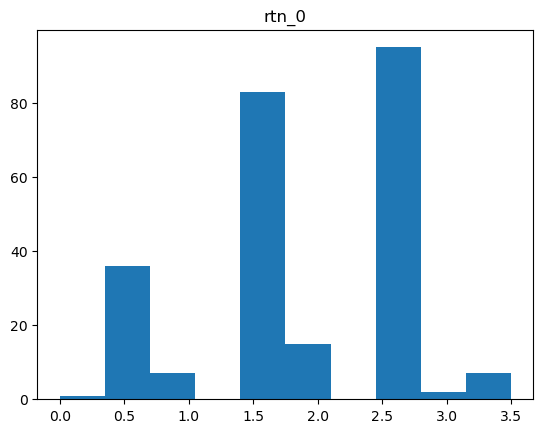

In [54]:
# summary stats for trades vs rtns

sym = "BANANAS"
waits=[-1, 0, 1, 3, 10, 30, 100]

df = calc_rtns(trade_df, sym=sym, waits=waits)
plt.hist(df["rtn_0"])
plt.title("rtn_0")

df["rtn_0_total"] = df["rtn_0"] * df["quantity"]

print("total profit", df["rtn_0_total"].sum())

display(df[[f"rtn_{wait}" for wait in waits]].describe().T)

### rtn vs quantity graph

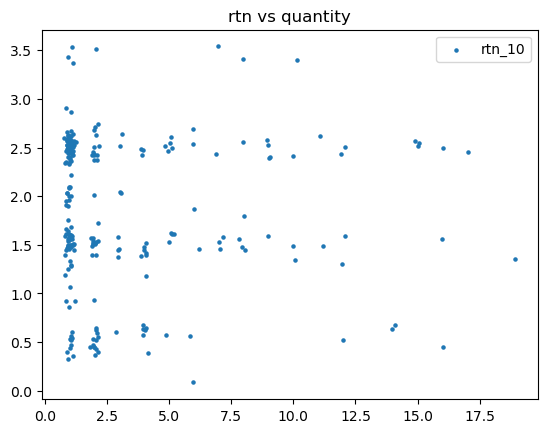

In [55]:
plt.scatter(blur(df["quantity"], std=0.1), blur(df["rtn_0"], std=0.1), s=5, label="rtn_10")
plt.title("rtn vs quantity")
plt.legend()
plt.show()



### large trades

In [56]:
# print out large trades

sizes = df.groupby("time")[["quantity"]].sum()
big_days = sizes[sizes["quantity"] >= 15]
df[df["time"].isin(big_days.index)]

,buyer,price,quantity,seller,symbol,order_time,time,turn,is_me,my_buy,...,BANANAS_100,PEARLS_100,rtn_-1,rtn_0,rtn_1,rtn_3,rtn_10,rtn_30,rtn_100,rtn_0_total
44,SUBMISSION,4895.0,15,,BANANAS,19300,19400,194,True,True,...,4890.5,10000.0,1.5,2.5,2.5,1.5,0.5,-0.5,-4.5,37.5
62,,4896.0,17,SUBMISSION,BANANAS,24400,24500,245,True,False,...,4887.5,10000.0,2.5,2.5,3.0,3.5,3.5,4.5,8.5,42.5
72,,4894.0,15,SUBMISSION,BANANAS,27500,27600,275,True,False,...,4886.5,10000.0,2.5,2.5,2.5,2.5,3.5,4.5,7.5,37.5
85,SUBMISSION,4887.0,16,,BANANAS,33000,33100,330,True,True,...,4889.0,10000.0,1.5,0.5,0.5,1.5,0.5,-0.5,2.0,8.0
97,SUBMISSION,4885.0,5,,BANANAS,40500,40600,405,True,True,...,4893.5,10000.0,2.5,1.5,1.5,1.5,2.5,4.5,8.5,7.5
98,,4890.0,10,SUBMISSION,BANANAS,40500,40600,405,True,False,...,4893.5,10000.0,2.5,3.5,3.5,3.5,2.5,0.5,-3.5,35.0
124,SUBMISSION,4892.0,15,,BANANAS,51500,51600,515,True,True,...,4896.0,10000.0,2.5,2.5,2.5,2.5,2.5,3.5,4.0,37.5
178,,4898.0,16,SUBMISSION,BANANAS,73800,73900,738,True,False,...,4896.0,10000.0,2.5,2.5,2.5,3.5,4.5,1.5,2.0,40.0
203,,4898.0,16,SUBMISSION,BANANAS,82900,83000,829,True,False,...,4891.5,10000.0,2.5,1.5,1.5,1.0,2.5,5.5,6.5,24.0
224,SUBMISSION,4889.0,19,,BANANAS,89500,89600,895,True,True,...,4892.5,10000.0,2.5,1.5,1.5,0.5,1.5,2.5,3.5,28.5


### losers: trade/book graph

In [57]:
losers = df[(df["rtn_10"] < 0)]
winners = df[df["rtn_10"] > 0]

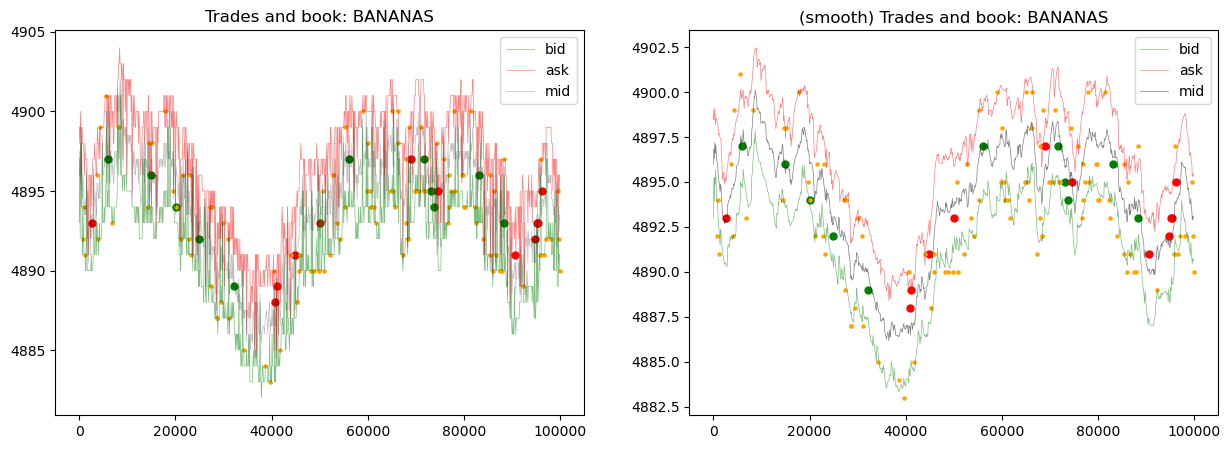

In [58]:
plot_trades_and_book(
    sym="BANANAS", 
    trade_df=pd.concat([losers, market_trades], axis=0), 
    book_df=book_tops, 
    time_lb=0, 
    time_ub=2e5, 
    span=10,
    show_mid=True,
)


In [59]:
losers

,buyer,price,quantity,seller,symbol,order_time,time,turn,is_me,my_buy,...,BANANAS_100,PEARLS_100,rtn_-1,rtn_0,rtn_1,rtn_3,rtn_10,rtn_30,rtn_100,rtn_0_total
9,,4893.0,6,SUBMISSION,BANANAS,2600,2700,27,True,False,...,4895.5,10000.0,0.5,0.5,-0.5,-1.0,-2.0,-5.0,-2.5,3.0
14,SUBMISSION,4897.0,2,,BANANAS,5800,5900,59,True,True,...,4895.5,10000.0,0.5,1.0,0.5,0.5,-0.5,2.5,-1.5,2.0
33,SUBMISSION,4896.0,4,,BANANAS,14800,14900,149,True,True,...,4892.5,10000.0,0.5,0.5,0.5,0.5,-0.5,1.5,-3.5,2.0
46,SUBMISSION,4894.0,7,,BANANAS,20000,20100,201,True,True,...,4890.5,10000.0,2.5,1.5,2.5,1.5,-0.5,0.5,-3.5,10.5
64,SUBMISSION,4892.0,1,,BANANAS,24800,24900,249,True,True,...,4887.5,10000.0,0.5,0.5,0.5,1.0,-0.5,-0.5,-4.5,0.5
82,SUBMISSION,4889.0,2,,BANANAS,32100,32200,321,True,True,...,4890.5,10000.0,1.5,0.5,0.5,-0.5,-1.5,-2.5,1.5,1.0
99,,4888.0,1,SUBMISSION,BANANAS,40700,40800,407,True,False,...,4893.5,10000.0,1.5,1.5,1.5,0.5,-0.5,-1.5,-5.5,1.5
101,,4889.0,7,SUBMISSION,BANANAS,41100,41200,411,True,False,...,4893.5,10000.0,1.5,1.5,1.5,0.5,-1.5,-0.5,-4.5,10.5
110,,4891.0,1,SUBMISSION,BANANAS,44700,44800,447,True,False,...,4896.5,10000.0,1.5,0.5,0.5,0.5,-1.5,-2.5,-5.5,0.5
122,,4893.0,2,SUBMISSION,BANANAS,50000,50100,500,True,False,...,4896.5,10000.0,0.5,0.5,-0.0,-0.5,-1.0,-2.0,-3.5,1.0


## Trade analysis - PEARLS

### rtn over time

total prof 1480.0


,count,mean,std,min,25%,50%,75%,max
rtn_-1,235.0,2.314894,0.741614,1.0,2.0,2.0,3.0,4.0
rtn_0,235.0,2.314894,0.741614,1.0,2.0,2.0,3.0,4.0
rtn_1,235.0,2.314894,0.741614,1.0,2.0,2.0,3.0,4.0
rtn_3,235.0,2.314894,0.741614,1.0,2.0,2.0,3.0,4.0
rtn_10,235.0,2.314894,0.741614,1.0,2.0,2.0,3.0,4.0
rtn_30,235.0,2.314894,0.741614,1.0,2.0,2.0,3.0,4.0
rtn_100,235.0,2.314894,0.741614,1.0,2.0,2.0,3.0,4.0


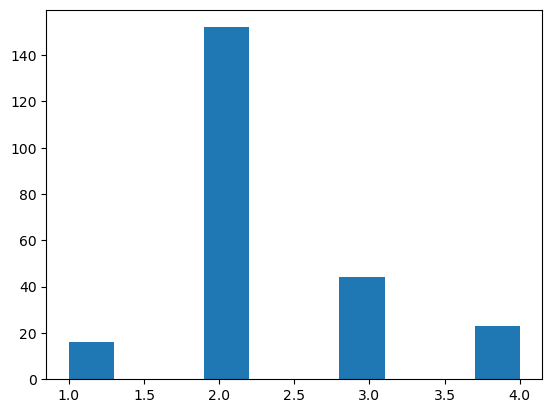

In [60]:
### summary stats for trades vs rtns

sym = "PEARLS"
waits=[-1, 0, 1, 3, 10, 30, 100]

df = calc_rtns(trade_df, sym=sym, waits=waits)
plt.hist(df["rtn_0"])

df["rtn_0_total"] = df["rtn_0"] * df["quantity"]

print("total prof", df["rtn_0_total"].sum())

display(df[[f"rtn_{wait}" for wait in waits]].describe().T)

### rtn vs quantity graph

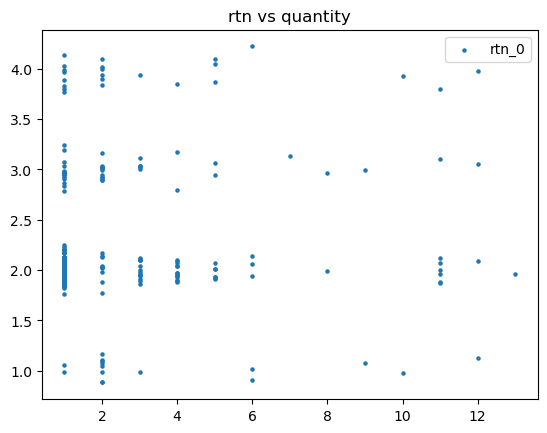

In [61]:
plt.scatter(blur(df["quantity"], std=0.0), blur(df["rtn_0"], std=0.1), s=5, label="rtn_0")
# plt.scatter(blur(df["quantity"]), blur(df["rtn_100"]), s=5, label="rtn_100")
plt.title("rtn vs quantity")
plt.legend()
plt.show()



### losers: rtn0 vs spread

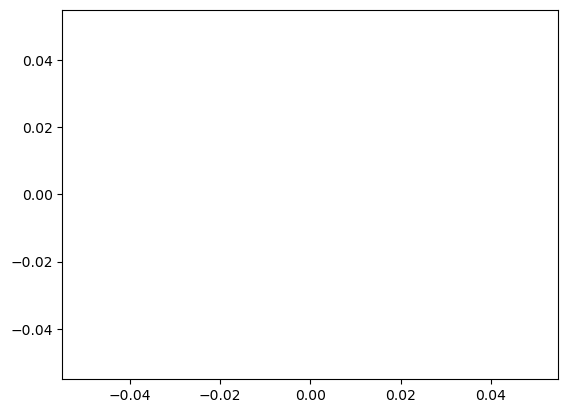

In [62]:
losers = df[(df["rtn_0"] < 0)]
winners = df[df["rtn_0"] > 0]

df = pd.merge(losers, book_tops[["BANANAS_spread", "time"]].shift(1), on="time")
plt.scatter(blur(df["BANANAS_spread"]), blur(df["rtn_0"]), s=5)

In [63]:
losers.describe().T

,count,mean,std,min,25%,50%,75%,max
price,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quantity,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_time,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
turn,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
my_quantity,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ref_ema,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quote_mid,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fair_value,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
buy_edge,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### losers: histogram of price changes

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

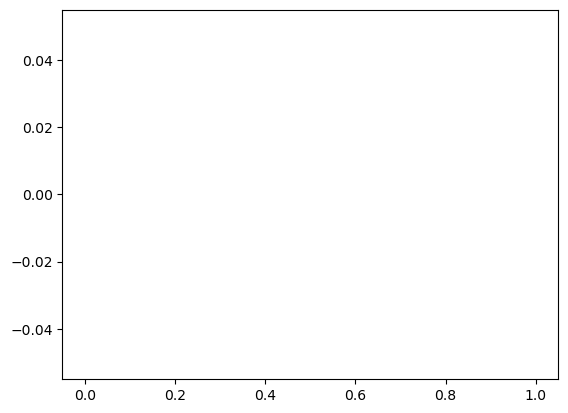

In [64]:
loser_diffs = (abs(losers["PEARLS_-1"] - losers["PEARLS_0"]))

plt.hist(loser_diffs)

### losers: trade/book graph

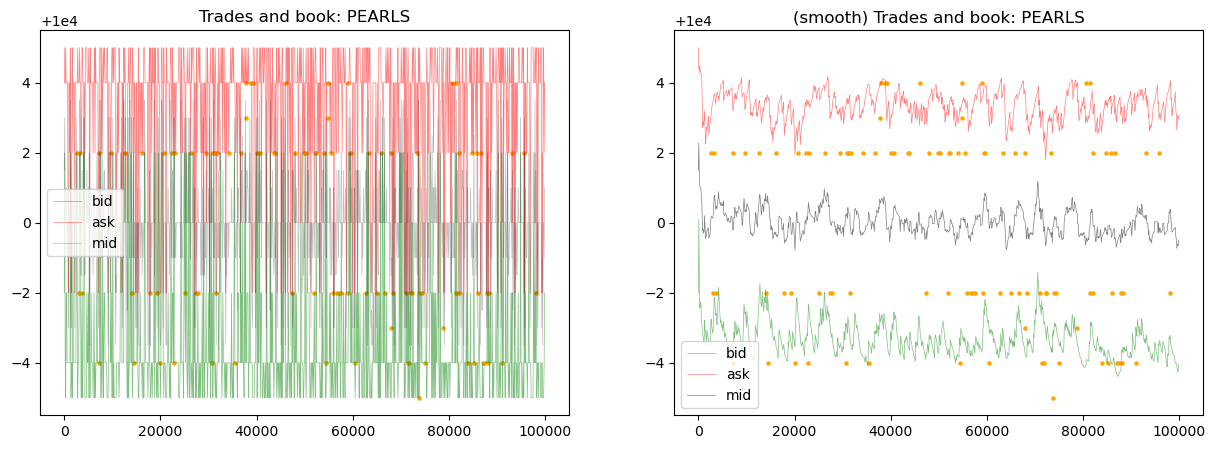

In [65]:
plot_trades_and_book(
    sym="PEARLS", 
    trade_df=pd.concat([losers, market_trades], axis=0), 
    book_df=book_tops, 
    time_lb=0, 
    time_ub=100000, 
    span=21,
    show_mid=True,
)
